# Practice: question answering with retrieval

In this homework you will build a retrieval-based question answering system, one component at a time.

_Okay, realistically, there's like, two components, but technically it's one component at a time._


![img](https://www.cs.upc.edu/~mlatifi/index_files/qa-logo.jpg)



There are two parts to this type of systems: a retriever and a generator.
- the retriever subsystem searches for similar texts from a given databse, e.g. wikipedia
- the generator uses the texts found by the retriever to generate an answer in natural language

_this seminar is based on original notebook by [Oleg Vasilev](https://github.com/Omrigan/)_



### Retriever training: loss function (2 points)
We want our vectorizers to put correct answers closer to question vectors and incorrect answers farther away from them. One way to express this is to use is Pairwise Hinge Loss _(aka Triplet Loss)_.

$$ L = \frac 1N \underset {q, a^+, a^-} \sum max(0, \space \delta - sim[V_q(q), V_a(a^+)] + sim[V_q(q), V_a(a^-)] )$$

, where
* sim[a, b] is some similarity function: dot product, cosine or negative distance
* δ - loss hyperparameter, e.g. δ=1.0. If sim[a, b] is linear in b, all δ > 0 are equivalent.


This reads as __Correct answers must be closer than the wrong ones by at least δ.__

![img](https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/margin.png)
<center>_image: question vector is green, correct answers are blue, incorrect answers are red_</center>


Note: in effect, we train a Deep Semantic Similarity Model [DSSM](https://www.microsoft.com/en-us/research/project/dssm/).

### Optional tasks for bonus points

There are many ways to improve our question answering model. Here's a bunch of things you can do to increase your understanding and get bonus points.

### 1.  Hard Negatives (2+ pts)

Not all wrong answers are equally wrong. As the training progresses, _most negative examples $a^-$ will be to easy._ So easy in fact, that loss function and gradients on such negatives is exactly __0.0__. To improve training efficiency, one can __mine hard negative samples__.

Given a list of answers,
* __Hard negative__ is the wrong answer with highest similarity with question,

$$a^-_{hard} = \underset {a^-} {argmax} \space sim[V_q(q), V_a(a^-)]$$

* __Semi-hard negative__ is the one with highest similarity _among wrong answers that are farther than positive one. This option is more useful if some wrong answers may actually be mislabelled correct answers.

* One can also __sample__ negatives proportionally to $$P(a^-_i) \sim e ^ {sim[V_q(q), V_a(a^-_i)]}$$


The task is to implement at least __hard negative__ sampling and apply it for model training.


### 2. Better prompting (2+ pts)

In the previous example, we manually engineer a prompt for an LLM to solve produce an answer. However, by this point you know multiple ways to make LLM do your bidding. In this assignment, you should try at least some of them:
- try few-shot learning with several handcrafted examples (or hand-picked model inputs)
- compare several instruct and/or non-instruct models; for non-instruct models
  - please not that you should not use apply_chat_template for non-instruct models
- provide some means of quality evaluation to compare your approach against the default one

At the minimum, several (10-20) side-by-side examples would do the trick. However, we'd appreciate creative means of evaluation here (crowdsourcing, asking another LM, anything exotic as long as you can explain it).

### 3. Search engine (3+ pts)

Our basic model only selects answers from 2-5 available sentences in paragraph. You can extend it to search over __the whole dataset__. All sentences in all other paragraphs are viable answers.

The goal is to train such a model and use it to __quickly find top-10 answers from the whole set__.

* You can ask such model a question of your own making - to see which answers it can find among the entire training dataset or even the entire wikipedia.
* Searching for top-K neighbors is easier if you use specialized methods: [KD-Tree](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html) or [HNSW](https://github.com/nmslib/hnswlib).
* This task is much easier to train if you use hard or semi-hard negatives. You can even find hard negatives for one question from correct answers to other questions in batch - do so in-graph for maximum efficiency. See [1.] for more details.


# Doing Bonus 1 below:-

In [ ]:
!pip install --upgrade accelerate

In [ ]:
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # use 'cuda' for any GPU

In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
%pip install --quiet transformers==4.36.2 accelerate==0.24.0 sentencepiece==0.1.99 optimum==1.13.2 auto-gptq==0.4.2
# ^-- if this fails, remove the specific version and install latest ones: pip install --update transformers accelerate ...
!wget https://raw.githubusercontent.com/yandexdataschool/nlp_course/2023/week_extra/retrieval/data.py -O data.py
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O squad-v2.0.json 2> log

import data
# backup download link: https://www.dropbox.com/s/q4fuihaerqr0itj/squad.tar.gz?dl=1
train, test = data.build_dataset('./squad-v2.0.json')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 979.5 kB/s eta 0:00:000:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.0/301.0 kB 11.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 89.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 77.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from transformers import AutoTokenizer, AutoModel, pipeline

model_name = 'sentence-transformers/bert-base-nli-mean-tokens'
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert = AutoModel.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
2025-05-05 17:25:17.030376: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746465917.289443      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746465917.361622      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.regis

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
class Vectorizer(nn.Module):
    def __init__(self, hid_size=256, bert=bert):
        """ A small feedforward network on top of pre-trained encoder. 2-3 layers should be enough """
        super().__init__()
        self.bert = bert
        self.hid_size = hid_size

        # define a few layers to be applied on top of pre-trained BERT
        # note: please make sure your final layer comes with _linear_ activation
        # <YOUR CODE HERE>
        # Freeze BERT parameters
        for param in self.bert.parameters():
            param.requires_grad = False

        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, hid_size)
        self.relu = nn.ReLU()
        self.to(device)


    def forward(self, input_phrases):
        """
        Apply vectorizer. Use dropout and any other hacks at will.
        :param input_phrases: a list of strings, [batch_size]
        :returns: predicted phrase vectors, [batch_size, output_size]

        Note: you may want to use dropouts.
        if self.training:
          <something>

        Note 2: you may also want to use with torch.no_grad to avoid training BERT for your first attempts

        """

        # In fact, please DO use at least 10% dropout!
        # <YOUR CODE>
        # return <...>
        with torch.no_grad():
            batch = tokenizer(input_phrases, padding=True, truncation=True, return_tensors="pt").to(device)
            outputs = self.bert(**batch)

        mask = batch['attention_mask'].unsqueeze(-1).float()
        token_embs = outputs.last_hidden_state
        phrase_embs = (token_embs * mask).sum(1) / mask.sum(1)

        x = self.dropout(phrase_embs)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x



In [ ]:
def similarity(a, b):
    """ Dot product as a similarity function """
    # <YOUR CODE>
    # return <...>
    return torch.sum(a * b, dim=1)


def compute_loss(question_vectors, correct_answer_vectors, wrong_answer_vectors, delta=1.0):
    """
    Compute the triplet loss as per formula above.
    Use similarity function above for  sim[a, b]
    :param question_vectors: float32[batch_size, vector_size]
    :param correct_answer_vectors: float32[batch_size, vector_size]
    :param wrong_answer_vectors: float32[batch_size, vector_size]
    :returns: loss for every row in batch, float32[batch_size]
    Hint: you can compute max(0, *) using torch.relu :)
    """
    # <YOUR CODE>
    # return <...>
    pos_sim = similarity(question_vectors, correct_answer_vectors)
    neg_sim = similarity(question_vectors, wrong_answer_vectors)
    print(torch.relu(delta - pos_sim + neg_sim))
    return torch.relu(delta - pos_sim + neg_sim)

# 1.

In [ ]:
from transformers import AutoTokenizer, AutoModel, pipeline

model_name = 'sentence-transformers/bert-base-nli-mean-tokens'
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert = AutoModel.from_pretrained(model_name)

In [ ]:
# Modified Data Loader with Hard Negatives
def iterate_hard_negatives(data, batch_size=256):
    indices = np.random.permutation(len(data))
    for i in range(0, len(data), batch_size):
        batch = data.iloc[indices[i:i+batch_size]]

        # Precompute all answer vectors
        all_answers = [ans for row in batch['options'] for ans in row]
        with torch.no_grad():
            all_ans_vecs = answer_vectorizer(all_answers)

        hardest_negs = []
        for idx, row in batch.iterrows():
            with torch.no_grad():
                q_vec = question_vectorizer([row['question']])
                wrong_vecs = all_ans_vecs[row['wrong_indices']]
                sims = F.cosine_similarity(q_vec, wrong_vecs)
                hardest_idx = torch.argmax(sims)
                hardest_negs.append(wrong_vecs[hardest_idx].cpu().numpy())

        yield {
            'questions': batch['question'].values,
            'correct_answers': [row['options'][c] for c in row['correct_indices']],
            'hard_negatives': hardest_negs
        }


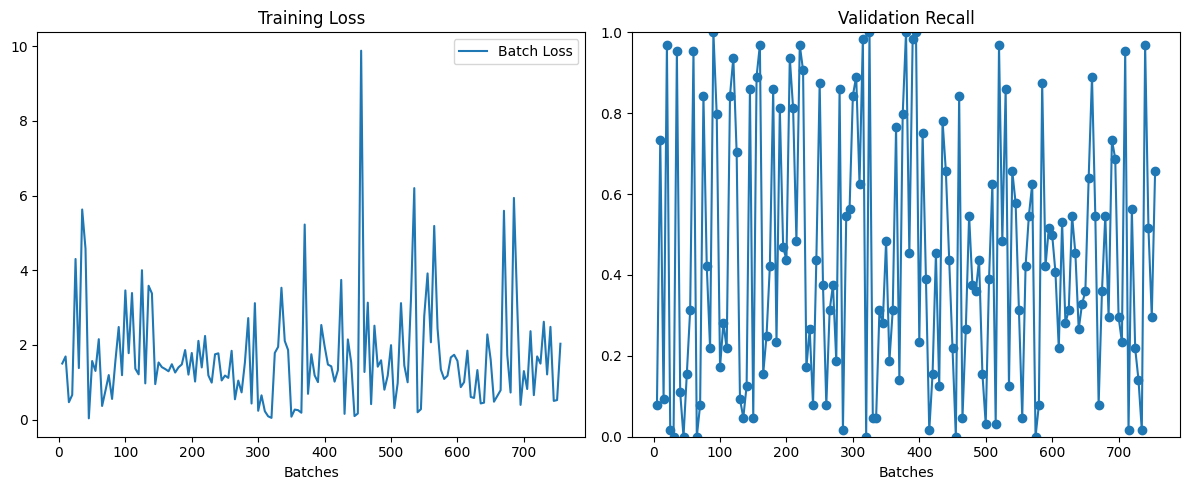

756it [50:09,  3.74s/it]

tensor([2.1451, 1.7197, 1.0658, 0.0000, 1.2737, 2.9827, 1.5685, 0.6147, 0.0000,
        0.7700, 1.9548, 2.3350, 0.7329, 0.4373, 1.5486, 0.1926, 1.9823, 0.0000,
        0.0000, 5.9535, 4.7273, 1.4860, 0.8542, 1.7225, 3.8116, 1.3143, 4.2328,
        0.0000, 0.0000, 0.0000, 0.6253, 0.0000, 0.0000, 3.8659, 0.6324, 1.3354,
        0.0000, 0.0000, 3.3716, 0.6679, 5.6949, 2.6151, 0.7037, 3.9106, 3.9257,
        3.4285, 1.7671, 0.3944, 0.4646, 3.0237, 1.0814, 2.8701, 1.8181, 0.0000,
        0.0000, 0.0000, 3.4041, 2.4090, 0.7674, 1.2346, 4.2259, 2.8185, 3.3070,
        0.0000], device='cuda:0', grad_fn=<ReluBackward0>)


756it [50:12,  3.98s/it]


KeyboardInterrupt: 

In [ ]:
# Modified Training Loop with Visualization
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from IPython.display import clear_output

# Initialize model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
question_vectorizer = Vectorizer().to(device)
answer_vectorizer = Vectorizer().to(device)
optimizer = torch.optim.AdamW(
    list(question_vectorizer.parameters()) + list(answer_vectorizer.parameters()),
    lr=2e-4,
    weight_decay=0.01
)

# Training parameters
train_loss = []
val_recall = []
batch_updates = []
update_interval = 5  # Plot every 5 batches changed from 50

# Training loop with hard negatives
for batch_idx, batch in enumerate(tqdm(iterate_hard_negatives(train, 64))):#changed from 256
    # Training step
    optimizer.zero_grad()

    # Convert to tensors
    # questions = batch['questions']
    questions = [str(q) for q in batch['questions']]  # Convert numpy elements to strings
    # correct_answers = batch['correct_answers']
    correct_answers = [str(a) for a in batch['correct_answers']]
    hard_negatives = torch.tensor(np.array(batch['hard_negatives'])).float().to(device)

    # Forward pass
    q_vecs = question_vectorizer(questions)
    a_pos_vecs = answer_vectorizer(correct_answers)

    # Compute loss
    # loss = compute_loss(q_vecs, a_pos_vecs, hard_negatives)
    loss = compute_loss(q_vecs, a_pos_vecs, hard_negatives).mean()

    # Backpropagate
    loss.backward()
    optimizer.step()

    # Store metrics
    train_loss.append(loss.item())

    # Validation and plotting
    if (batch_idx + 1) % update_interval == 0:
        # Compute validation recall
        val_batch = next(iterate_hard_negatives(test, 64))# changed from 256
        with torch.no_grad():
            q_val = question_vectorizer([str(q) for q in val_batch['questions']])
            a_pos_val = answer_vectorizer([str(a) for a in val_batch['correct_answers']])
            # a_neg_val = answer_vectorizer(val_batch['hard_negatives'])
            a_neg_val = torch.tensor(np.array(val_batch['hard_negatives'])).float().to(device)


            pos_sim = similarity(q_val, a_pos_val)
            neg_sim = similarity(q_val, a_neg_val)
            recall = (pos_sim > neg_sim).float().mean().item()

        val_recall.append(recall)
        batch_updates.append(batch_idx + 1)

        # Update plots
        clear_output(wait=True)
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.title("Training Loss")
        plt.plot(batch_updates, train_loss[-len(batch_updates):], label='Batch Loss')
        # plt.plot(batch_updates, pd.Series(train_loss).ewm(span=50).mean().values[-len(batch_updates):],
        #         label='EMA Loss')
        plt.xlabel("Batches")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.title("Validation Recall")
        plt.plot(batch_updates, val_recall, 'o-')
        plt.ylim(0, 1)
        plt.xlabel("Batches")

        plt.tight_layout()
        plt.show()

print(f"Final Validation Recall: {np.mean(val_recall[-10:]):.2%}")

# Didn't get enough accuracy or converged. But, It should happen with more memory and training time. Unable to use batch size greater than 64 because of less memory.